An example showing how the LogD predictor can be used to calculate the Solubility Forecast Index (SFI).  As a refresher, the SFI was originally defined in this paper.  

Hill, Alan P., and Robert J. Young. "Getting physical in drug discovery: a contemporary perspective on solubility and hydrophobicity." Drug Discovery Today 15.15-16 (2010): 648-655. [https://doi.org/10.1016/j.drudis.2010.05.016](https://doi.org/10.1016/j.drudis.2010.05.016)

**SFI = CLogD + #Aromatic Rings**



In [4]:
from sfi_predictor import SFIPredictor
from tqdm import tqdm
from rdkit import RDLogger 
from rdkit import Chem
from rdkit.Chem import Descriptors
import seaborn as sns
import pandas as pd
import numpy as np
from constants import SFI_MODULE
import chembl_downloader
import pystow

In [9]:
sol_df = pd.read_csv("biogen_solubility.csv")

Enable Pandas progress_apply

In [10]:
tqdm.pandas()
sns.set()

Define a SFIPredictor object

In [11]:
chembl_version = chembl_downloader.latest()
path = SFI_MODULE.join(chembl_version, name="model.txt")
sfi_predictor = SFIPredictor(path)

Calculate LogD for the dataset

In [12]:
RDLogger.DisableLog('rdApp.*')  
sol_df['SFI'] = sol_df.SMILES.progress_apply(sfi_predictor.predict_smiles)
RDLogger.EnableLog('rdApp.*')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2173/2173 [00:24<00:00, 87.53it/s]


Make sure we don't have any molecules where the calculations failed

In [13]:
sol_df.shape, sol_df.dropna().shape

((2173, 5), (2173, 5))

Define a function to make plots like the one in the paper

In [17]:
def get_fractions(vc):
    low = vc['Low']
    med = vc['Medium']
    hi = vc['High']
    total = low + med + hi
    if total > 0:
        res = [x/total for x in [low,med,hi]]
    else:
        res = [0,0,0]
    return res
    

def sfi_plot(df,sfi_column='SFI',logS_column="LogS"):
    df['Label'] = pd.cut(df[logS_column],bins=[-100] + [np.log10(x*1e-06) for x in [30,200]] + [100],labels=["Low","Medium","High"])
    sfi_bins = [-100] + list(range(1,13)) + [100]
    sfi_labels = ['<1'] +[f"{x}-{x+1}" for x in range(1,12)] + [">12"]
    df['sfi_bin'] = pd.cut(df[sfi_column],bins=sfi_bins,labels=sfi_labels)
    res = []
    bin_counts = []
    for k,v in df.groupby('sfi_bin'):
        res.append([k]+get_fractions(v.Label.value_counts()))
        bin_counts.append(len(v))
    sfi_df = pd.DataFrame(res,columns=["SFI","Low","Med","High"])
    sns.set()
    sns.set(rc={'figure.figsize': (10, 10)})
    sns.set_style('white')
    sns.set_context('talk')
    ax = sfi_df.set_index("SFI").plot(kind="bar",stacked="True",color=['red','yellow','green'])
    ax.set_xlabel("SFI Bin")
    ax.set_ylabel('Count')
    pos = -0.4
    for b in bin_counts:
        ax.text(pos,1.01,str(b).center(4))
        pos = pos+1.0
    ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1)

Draw the plot

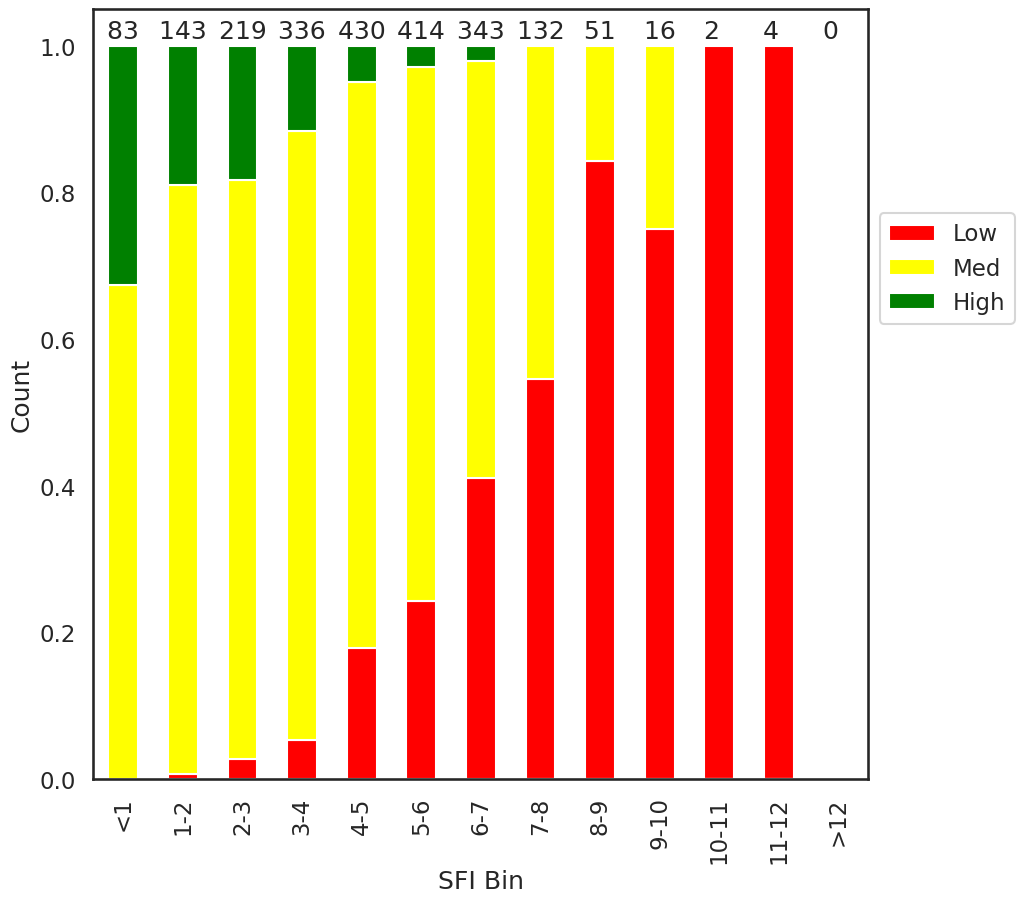

In [18]:
sfi_plot(sol_df,sfi_column='SFI',logS_column="logS")